In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import re
from os import listdir
from scipy.ndimage import gaussian_filter
from sklearn.mixture import gaussian_mixture
from scipy import fft, ifft
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42

In [7]:
pixsize = 8190/60/1.5/1.2/512 #um
dataname_list = [['5ITu_01Pos0','5ITu_03Pos6','DMSO_01Pos7','DMSO_01Pos10',
                 'Taxol_01Pos7','Taxol_01Pos8','Taxol+5ITu_01Pos6'],
                 ['5ITu_01Pos13','5ITu_02Pos7','5ITu_03Pos1',
                'DMSO_01Pos0','DMSO_01Pos4','DMSO_01Pos9',
               'Taxol_01Pos5','Taxol_02Pos12','Taxol_02Pos14',
               'Taxol+5ITu_03Pos5'],
                 ['5ITu_03Pos0','DMSO_01Pos5','DMSO_01Pos6','DMSO_01Pos10','DMSO_02Pos6',
                 'Taxol_01Pos2']]
linepath_list = ['20171006_LineProfiles/','20171009_LineProfiles/','20171012_LineProfiles/']
imagepath_list = ['20171006_ImageSequences/','20171009_ImageSequences/','20171012_ImageSequences/']

trange0 = np.arange(1,4)   #No treatment
trange1 = np.arange(4,7)   #First treatment (5ITu or Taxol or DMSO)
trange2 = np.arange(7,10)  #Second treatment (5ITu+Taxol)


# pixsize = 8190/60/1.5/512 #um
# dataname_list = [['DMSO_01Pos0','DMSO_01Pos2','DMSO_01Pos6','5ITu_02Pos5',
#                   '5ITu_02Pos8','5ITu_02Pos9','5ITu_03Pos1']]
# linepath_list = ['20170411_LineProfiles/']

# trange0 = np.arange(0,5)   #No treatment
# trange1 = np.arange(10,15)   #First treatment (5ITu or DMSO)
# trange2 = []


# pixsize = 8190/60/1.5/1.2/512 #um
# dataname_list = [['DMSO_01Pos5','DMSO_01Pos6','DMSO_01Pos10','DMSO_02Pos6']]
# linepath_list = ['20171012_LineProfiles_lw1_DMSO/']

# trange0 = np.arange(1,4)   #No treatment
# trange1 = np.arange(4,7)   #First treatment (5ITu or DMSO)
# trange2 = np.arange(7,10)



kkdistrange = (0.65,1.75)  #in um

In [8]:
# normalize profiles such that the lowest value of average profile before treatment (trange0) is 0, 
#and the highest is 1. also filter out the K-K pairs with K-K distance out of range

def normalizeLineProfs(df_prof,trange0=trange0):
    #determine max 488, 560 intentsity
    mask = [t in trange0 for t in df_prof['tpoint']]

    prof488_mean = np.mean(df_prof.loc[mask,'prof488'].values,axis=0)
    prof560_mean = np.mean(df_prof.loc[mask,'prof560'].values,axis=0)

    maxint488 = np.max(prof488_mean)
    maxint560 = np.max(prof560_mean)
    
    minint488 = np.min(prof488_mean)
    minint560 = np.min(prof560_mean)

    prof488_norm = (df_prof['prof488']-minint488)/(maxint488-minint488)
    prof560_norm = (df_prof['prof560']-minint560)/(maxint560-minint560)

    df_prof['prof488_norm'] = prof488_norm
    df_prof['prof560_norm'] = prof560_norm
    
    return df_prof

In [9]:
# determine cytoplasmic background level
def getCytoBg(df_feat,imgpath,windowsize=20/pixsize):
    # Determine center of the cell
    x = df_feat.loc[df_feat['tpoint']==1,'x']
    y = df_feat.loc[df_feat['tpoint']==1,'y']

    cenx = np.mean(x)
    ceny = np.mean(y)

    # Load first timepoint images to compute cytoplasmic background level
    imgnamelist = np.array(listdir(imgpath))

    mask488 = [len(re.findall('\_t001_z\d*_c001',imgname))>0 for imgname in imgnamelist]
    mask560 = [len(re.findall('\_t001_z\d*_c002',imgname))>0 for imgname in imgnamelist]

    imgnamelist0_488 = imgnamelist[np.array(mask488)]
    imgnamelist0_560 = imgnamelist[np.array(mask560)]

    imgs488 = []
    filtimgs488 = []
    imgs560 = []
    filtimgs560 = []

    for fname in imgnamelist0_488:
        temp = plt.imread(imgpath+fname)
        imgs488.append(temp[int(ceny-windowsize/2):int(ceny+windowsize/2),int(cenx-windowsize/2):int(cenx+windowsize/2)])
        
    for img488 in imgs488:
        filtimgs488.append(gaussian_filter(np.double(img488),1))

    temp = np.array(filtimgs488)
    temp = temp.flatten()
    hh,edges = np.histogram(temp,bins=100)
    cytobg488 = np.mean(temp[(temp>edges[np.argmax(hh)]) & (temp<edges[np.argmax(hh)+1])])
    
    for fname in imgnamelist0_560:
        temp = plt.imread(imgpath+fname)
        imgs560.append(temp[int(ceny-windowsize/2):int(ceny+windowsize/2),int(cenx-windowsize/2):int(cenx+windowsize/2)])

    for img560 in imgs560:
        filtimgs560.append(gaussian_filter(np.double(img560),1))

    temp = np.array(filtimgs560)
    temp = temp.flatten()
    hh,edges = np.histogram(temp,bins=100)
    cytobg560 = np.mean(temp[(temp>edges[np.argmax(hh)]) & (temp<edges[np.argmax(hh)+1])])
    
    return cytobg488,cytobg560

In [10]:
# normalize profiles based on cytoplasmic background
def normalizeLineProfs_image(df_prof,cytobg488,cytobg560,trange0=trange0):
    
    #determine max 488, 560 intentsity
    mask = [t in trange0 for t in df_prof['tpoint']]

    prof488_mean = np.mean(df_prof.loc[mask,'prof488'].values,axis=0)
    prof560_mean = np.mean(df_prof.loc[mask,'prof560'].values,axis=0)

    maxint488 = np.max(prof488_mean)
    maxint560 = np.max(prof560_mean)
    
    prof488_norm = (df_prof['prof488']-cytobg488)/(maxint488-cytobg488)
    prof560_norm = (df_prof['prof560']-cytobg560)/(maxint560-cytobg560)

    df_prof['prof488_norm'] = prof488_norm
    df_prof['prof560_norm'] = prof560_norm
    
    return df_prof
    

In [23]:
Nsets = len(linepath_list)

df_prof_list = []
df_feat_list = []

for seti in range(Nsets):
    linepath = linepath_list[seti]
    imagepath = imagepath_list[seti]
    
    for dataname in dataname_list[seti]:
    
        #load features and profiles, and add kkdists (in pixels)
        df_feat = pd.read_csv(linepath+dataname+'_feat.csv')
        df_feat = df_feat.drop(df_feat.columns[0],axis=1)

        df_prof = pd.read_csv(linepath+dataname+'_prof.csv')
        df_prof = df_prof.drop(df_prof.columns[0],axis=1)
        df_prof[['prof488','prof560']] = df_prof[['prof488','prof560']].applymap(lambda x:np.array(eval(re.sub(r'(\d)\s+(\d)', r'\1,\2',x))))

        kkdists = []
        for i in df_prof.index:
            ids = df_prof.iloc[i][['kinid1','kinid2']].values
            fr = df_prof.iloc[i]['fr']
            feat_sel = df_feat.loc[(df_feat['frame']==fr) & ((df_feat['kinid']==ids[0]) | (df_feat['kinid']==ids[1]))]
            kkdists.append(np.linalg.norm(np.diff(feat_sel[['x','y']].values,axis=0)))

        df_prof['kkdist'] = kkdists
        
        df_prof['Data Name'] = 'Set%d_%s' %(seti,dataname)
        df_feat['Data Name'] = 'Set%d_%s' %(seti,dataname)
        
        #remove timepoints out of range
        grp = re.split('\_',dataname)[0]
        if (grp == 'DMSO') | (grp=='Taxol+5ITu'):
            mask = [(t in trange0) | (t in trange1) | (t in trange2) for t in df_prof['tpoint']]
        elif (grp == '5ITu') | (grp=='Taxol'):
            mask = [(t in trange0) | (t in trange1) for t in df_prof['tpoint']]
        else:
            print('Group cannot be defined for Set%d_%s' %(seti,dataname))
        
        df_prof = df_prof.loc[mask]
        
        # add 'Group' column
        df_prof['Group'] = 'NA'
        
        df_prof.loc[[(t in trange0) for t in df_prof['tpoint']],'Group'] = 'None'
        
        if (grp=='Taxol+5ITu'):
            df_prof.loc[[(t in trange1) for t in df_prof['tpoint']],'Group'] = 'Taxol'
            df_prof.loc[[(t in trange2) for t in df_prof['tpoint']],'Group'] = 'Taxol+5ITu'
        elif (grp == '5ITu') | (grp=='Taxol'):
            df_prof.loc[[(t not in trange0) for t in df_prof['tpoint']],'Group'] = grp
        elif (grp == 'DMSO'):
            df_prof.loc[[(t in trange1) for t in df_prof['tpoint']],'Group'] = 'DMSO'
            df_prof.loc[[(t in trange2) for t in df_prof['tpoint']],'Group'] = 'DMSO_cont'
        
        #filter out pairs with kk distance out of kkdistrange
        df_prof = df_prof.loc[(df_prof['kkdist']*pixsize>=kkdistrange[0]) & (df_prof['kkdist']*pixsize<=kkdistrange[1])]
        
#         #normalization
#         df_prof = normalizeLineProfs(df_prof)
        
        #cytoplasmic background estimation
        cytobg488,cytobg560 = getCytoBg(df_feat,imagepath+dataname+'/')
        df_prof = normalizeLineProfs_image(df_prof,cytobg488,cytobg560)
        
        df_prof_list.append(df_prof)
        df_feat_list.append(df_feat)
        
df_prof_all = pd.concat(df_prof_list)
df_feat_all = pd.concat(df_feat_list)
        


In [24]:
df_prof_all.head()

,fr,kinid1,kinid2,prof488,prof560,tpoint,kkdist,Data Name,Group,prof488_norm,prof560_norm
0,62,1,2,"[1715.61104389, 1660.82698656, 1723.76473817, ...","[2309.18362285, 2387.19508315, 2428.51903483, ...",5,8.606725,Set0_5ITu_01Pos0,5ITu,"[0.0234485307869, 0.0106680793977, 0.025350688...","[0.0939182298081, 0.108460950108, 0.1161644678..."
1,62,3,4,"[1552.99194217, 1605.54350962, 1709.46555837, ...","[2399.51239168, 2703.04284172, 2456.31356638, ...",5,7.514712,Set0_5ITu_01Pos0,5ITu,"[-0.0144885192561, -0.00222888048611, 0.022014...","[0.110757114954, 0.167340576158, 0.1213458617,..."
2,62,5,8,"[1883.33006817, 1654.57613023, 1707.94991737, ...","[2507.42374322, 2922.57186595, 2906.05319782, ...",5,10.134411,Set0_5ITu_01Pos0,5ITu,"[0.0625753304679, 0.00920983096999, 0.02166128...","[0.130873705473, 0.208264681215, 0.20518530839..."
3,62,9,10,"[1626.92035503, 1558.71545596, 1605.1989608, 1...","[2334.2213174, 2323.92138088, 2422.73869897, 2...",5,7.996866,Set0_5ITu_01Pos0,5ITu,"[0.00275807643042, -0.0131532934015, -0.002309...","[0.0985857002975, 0.096665609386, 0.1150869107..."
4,8,0,1,"[1626.34856482, 1705.3224774, 1767.25194104, 1...","[2190.95558673, 2080.73592642, 2036.92755967, ...",1,7.991368,Set0_5ITu_01Pos0,None,"[0.00262468475883, 0.0210483338994, 0.03549572...","[0.0718784262429, 0.0513315260153, 0.043164869..."


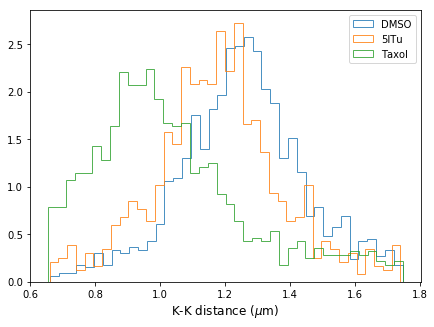

In [25]:
#Get histogram of K-K distance in each group
fs = 12
grped_df = df_prof_all.groupby('Group')
fig,ax = plt.subplots(figsize=(7,5))

#grp_to_plot = ['None','DMSO','5ITu','Taxol','DMSO_cont']
grp_to_plot = ['DMSO','5ITu','Taxol']
#grp_to_plot = ['DMSO','None']
for grp in grp_to_plot:
    plt.hist(grped_df.get_group(grp)['kkdist']*pixsize,bins=40,alpha=0.8,normed=True,histtype='step');
    
plt.legend(grp_to_plot)
plt.xlabel('K-K distance ($\mu$m)',fontsize=fs)
#fig.savefig('KKdistance_Histogram.pdf',facecolor=None,edgecolor=None)

In [26]:
grped_df.size()

Group
5ITu           869
DMSO          1214
DMSO_cont     1233
None          3074
Taxol         1026
Taxol+5ITu     207
dtype: int64

In [27]:
def findFWHM(prof,dx=0.1):
    x = np.arange(len(prof))
    f = sp.interpolate.interp1d(x,prof,kind='cubic')
    xnew,dx = np.linspace(0,np.max(x),np.int(np.max(x)/dx)+1,retstep=True)
    intp_prof = f(xnew)
    m = np.max(intp_prof)
    zero_crossings = np.where(np.diff(np.sign(intp_prof-m/2)))[0]
    return (zero_crossings[1]-zero_crossings[0])*dx

In [28]:
def int_at_kin(prof,kkdist):
    lenprof = len(prof)
    cen = (lenprof-1)/2.0
    return sp.interp([cen-kkdist/2.0,cen+kkdist/2.0],np.arange(lenprof),prof)

In [29]:
def wiener_deconvolution(signal, kernel, lambd):
    #"lambd is the SNR"
    D = len(signal) - len(kernel)
    kernel = np.hstack((kernel,np.zeros(D))) # zero pad the kernel to same length
    kernel = np.roll(kernel,-int(D/2.0)+2)
    H = fft(kernel)
    
    denom = H*np.conj(H) + lambd**2
    denom[denom<np.spacing(1)] = np.spacing(1)
    
    G = np.conj(H)/denom
    deconvolved = np.real(ifft(G*fft(signal)))
    
    return deconvolved

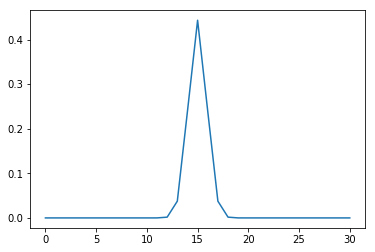

In [30]:
#1D PSF
x = np.arange(31)-15
sig = 0.9
psf = np.exp(-x**2/(2*sig**2))
psf = psf/np.sum(psf)
plt.plot(psf)

In [113]:
def getBinAvgProf(df_prof,nbins=5,kkdistrange=kkdistrange,pixsize=pixsize,edges=[]):
    # Average, sem of profiles within groups of pairs with similar K-K dists.
    # Either nbins or edges need to be provided

    #if bin edge is not provided, determine edges based on quantiles
    if len(edges) == 0: 
        df_prof = df_prof.loc[(df_prof['kkdist']*pixsize>=kkdistrange[0]) & (df_prof['kkdist']*pixsize<=kkdistrange[1])]
        labels,retbins = pd.qcut(df_prof['kkdist'],np.linspace(0,1,num=nbins+1),labels=np.arange(nbins),retbins=True)
    else:  # if edge is provided, nbins = len(edges)-1
        df_prof = df_prof.loc[(df_prof['kkdist']*pixsize>=edges[0]) & (df_prof['kkdist']*pixsize<=edges[-1])]
        retbins = edges
        nbins = len(edges)-1
        labels = np.zeros(df_prof.shape[0])
        for label in np.arange(nbins):
            labels[(df_prof['kkdist']*pixsize>=edges[label]) & (df_prof['kkdist']*pixsize<=edges[label+1])] = label
    
    res_dicts = []
    for i in np.arange(nbins):
        df = df_prof.loc[labels==i]
        
        avgprof488 = df['prof488_norm'].mean()
        semprof488 = np.std(df['prof488_norm'].values,axis=0)/np.sqrt(df.shape[0])
        avgprof560 = df['prof560_norm'].mean()
        semprof560 = np.std(df['prof560_norm'].values,axis=0)/np.sqrt(df.shape[0])
        
        avgkkdist = df['kkdist'].mean()
        sdkkdist = df['kkdist'].std()
        
        avgintatkin = df.apply(lambda row:np.mean(int_at_kin(row.prof560_norm,row.kkdist)),axis=1).mean()
        semintatkin = np.std(df.apply(lambda row:np.mean(int_at_kin(row.prof488_norm,row.kkdist)),axis=1).values,axis=0)/np.sqrt(df.shape[0])
        
        res_dicts.append({'kkdist_range':(retbins[i],retbins[i+1]),'avgprof488':avgprof488,'avgprof560':avgprof560,
                          'semprof488':semprof488,'semprof560':semprof560,'avgintatkin':avgintatkin,'semintatkin':semintatkin,
                         'avgkkdist':avgkkdist,'sdkkdist':sdkkdist,'N':df.shape[0]})
        
    return pd.DataFrame(res_dicts)

In [66]:
# import FLIM data mat files
from scipy import io
mat = io.loadmat('dist_all_result_bin8_WT.mat')
FLIMWT = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten()}

mat = io.loadmat('dist_all_result_bin8_Treated.mat')
FLIM5ITu = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten()}

mat = io.loadmat('dist_all_result_bin4_Taxol.mat')
FLIMTaxol = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten()}


In [84]:
FLIMWT

{'X': array([ 0.93598584,  1.01957209,  1.07489824,  1.1301308 ,  1.17820352,
         1.23382825,  1.29919858,  1.4177825 ]),
 'edges': array([ 0.8       ,  0.98152846,  1.04870877,  1.10051645,  1.15548273,
         1.20457958,  1.26347374,  1.35165985,  1.5       ]),
 'mean_FRET_fraction': array([ 0.10808453,  0.11324524,  0.10999011,  0.12253551,  0.11612882,
         0.12501623,  0.12771801,  0.12918167]),
 'std_FRET_fraction': array([ 0.00805953,  0.0069314 ,  0.00706251,  0.00650508,  0.00667699,
         0.00656927,  0.00643851,  0.00639655])}

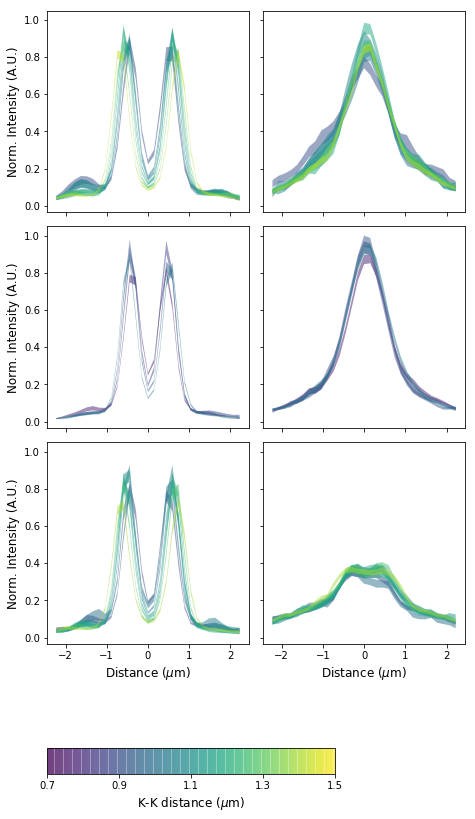

In [115]:
fs = 12
alph = 0.5

df_res_list = [getBinAvgProf(df_prof_all[(df_prof_all['Group']=='DMSO')],edges=FLIMWT['edges']),
               getBinAvgProf(df_prof_all[(df_prof_all['Group']=='Taxol')],edges=FLIMTaxol['edges']),
               getBinAvgProf(df_prof_all[(df_prof_all['Group']=='5ITu')],edges=FLIM5ITu['edges'])]
# df_res_list = [getBinAvgProf(df_prof_all[(df_prof_all['Group']=='DMSO')],nbins),
#                 getBinAvgProf(df_prof_all[(df_prof_all['Group']=='5ITu')],nbins)]


norm = mpl.colors.Normalize(vmin=0.7,vmax=1.5)
# choose a colormap
c_m = cm.viridis
# create a ScalarMappable and initialize a data structure
s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


proflen = len(df_res_list[0].iloc[0]['avgprof488'])
x = (np.arange(proflen)-(proflen-1)/2.0)*pixsize

fig,ax = plt.subplots(nrows=len(df_res_list),ncols=2,figsize=(8,4*len(df_res_list)),sharex=True,sharey=True)
for j,df_res in enumerate(df_res_list):
    nbins = df_res.shape[0]
    for i in range(nbins):
        ax[j][0].fill_between(x,df_res.iloc[i]['avgprof488']+df_res.iloc[i]['semprof488'],
                        df_res.iloc[i]['avgprof488']-df_res.iloc[i]['semprof488'],alpha=alph,
                             facecolor=s_m.to_rgba(df_res.iloc[i]['avgkkdist']*pixsize))
        ax[j][1].fill_between(x,df_res.iloc[i]['avgprof560']+df_res.iloc[i]['semprof560'],
                        df_res.iloc[i]['avgprof560']-df_res.iloc[i]['semprof560'],alpha=alph,
                             facecolor=s_m.to_rgba(df_res.iloc[i]['avgkkdist']*pixsize))
        
        ax[j][0].set_ylabel('Norm. Intensity (A.U.)',fontsize=fs)

ax[len(df_res_list)-1][0].set_xlabel('Distance ($\mu$m)',fontsize=fs)
ax[len(df_res_list)-1][1].set_xlabel('Distance ($\mu$m)',fontsize=fs)

plt.tight_layout()
fig.subplots_adjust(bottom=0.25,left=0.25)

cax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
cb = fig.colorbar(s_m,orientation='horizontal',cax=cax,ticks=[0.7,0.9,1.1,1.3,1.5],alpha=alph)
cb.set_label('K-K distance ($\mu$m)',fontsize=fs)

#fig.savefig('NormProfiles_cytobgNorm.pdf',facecolor=None,edgecolor=None)
#fig.savefig('NormProfiles.pdf',facecolor=None,edgecolor=None)

In [130]:
# number of kinetochores and cells in each data
print([df_res['N'].sum() for df_res in df_res_list])
grped = df_prof_all[['Data Name','Group']].groupby('Group')
print([len(np.unique(grped.get_group(grp)['Data Name'])) for grp in ['DMSO','Taxol','5ITu']])

[1072, 670, 783]
[9, 8, 6]


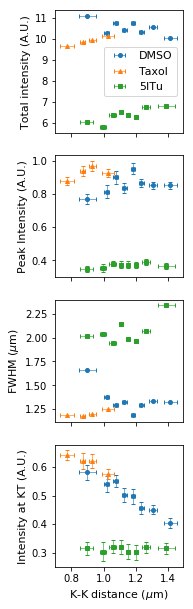

In [111]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(2.7,8.6),sharex=True)
fmts = ['o','^','s']
fs = 11
ms=4
ew = 0.6
for j,df_res in enumerate(df_res_list):
    ax[0].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.sum),
                   xerr=df_res['sdkkdist']*pixsize,fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[1].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.max),xerr=df_res['sdkkdist']*pixsize,
                   yerr=df_res.apply(lambda row:row['semprof560'][np.argmax(row['avgprof560'])],axis=1),
                   fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[2].errorbar(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(findFWHM)*pixsize,
                   xerr=df_res['sdkkdist']*pixsize,fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    ax[3].errorbar(df_res['avgkkdist']*pixsize,df_res['avgintatkin'],
                   xerr=df_res['sdkkdist']*pixsize,yerr=df_res['semintatkin'],
                   fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew)
    
ax[0].set_ylabel('Total intensity (A.U.)',fontsize=fs)
ax[1].set_ylabel('Peak Intensity (A.U.)',fontsize=fs)
ax[0].legend(['DMSO','Taxol','5ITu'],fontsize=fs)
#ax[0].legend(['DMSO','5ITu'],fontsize=fs)
ax[2].set_ylabel('FWHM ($\mu$m)',fontsize=fs)
ax[3].set_ylabel('Intensity at KT (A.U.)',fontsize=fs)
ax[3].set_xlabel('K-K distance ($\mu$m)',fontsize=fs)

plt.tight_layout()

fig.savefig('AnalysisSummary_cytobgNorm.pdf',facecolor=None,edgecolor=None)
#fig.savefig('AnalysisSummary.pdf',facecolor=None,edgecolor=None)

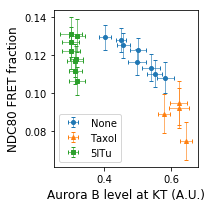

In [112]:
fs=12
FLIM_list = [FLIMWT,FLIMTaxol,FLIM5ITu]
fmts = ['o','^','s']
ms=4
ew=0.6

fig = plt.figure(figsize=(3,3))
for i in range(3):
    plt.errorbar(df_res_list[i]['avgintatkin'],FLIM_list[i]['mean_FRET_fraction'],
                 xerr=df_res_list[i]['semintatkin'],yerr=FLIM_list[i]['std_FRET_fraction'],
                 fmt=fmts[i],capsize=2,mec=None,ms=ms,elinewidth=ew)
    
plt.xlabel('Aurora B level at KT (A.U.)',fontsize=fs)
plt.ylabel('NDC80 FRET fraction',fontsize=fs)
plt.legend(['None','Taxol','5ITu'])
plt.tight_layout()

fig.savefig('AuroraB_vs_NDC80FRETfraction.pdf',edgecolor=None,facecolor=None)

/Users/tyyoo/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/Users/tyyoo/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


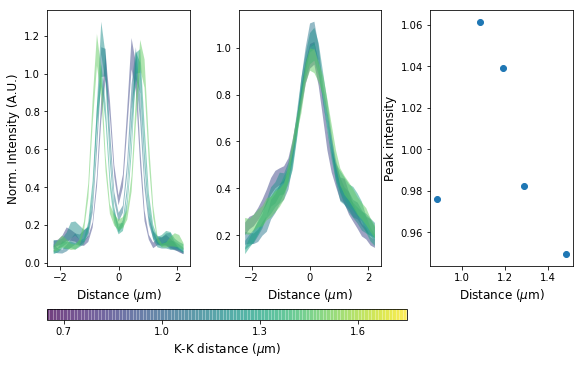

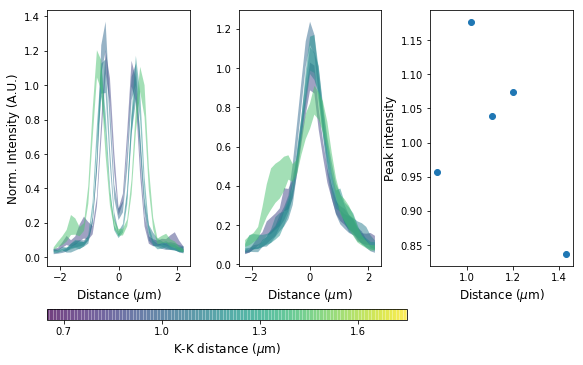

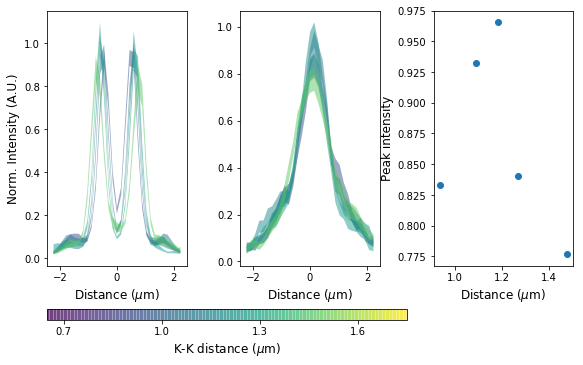

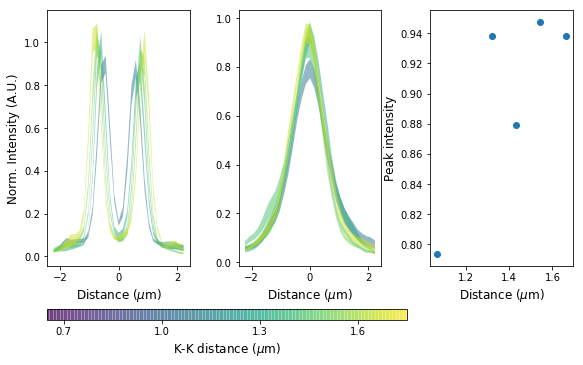

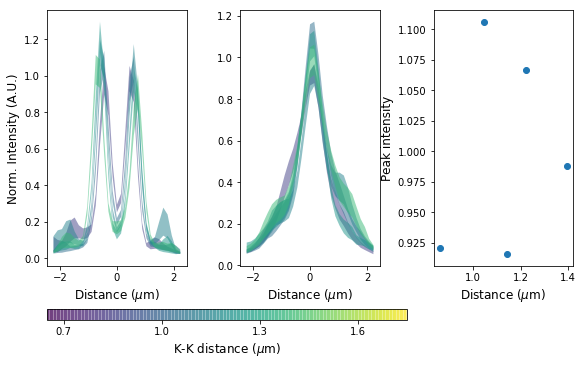

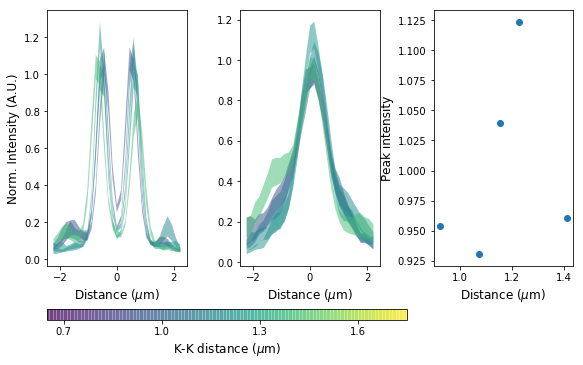

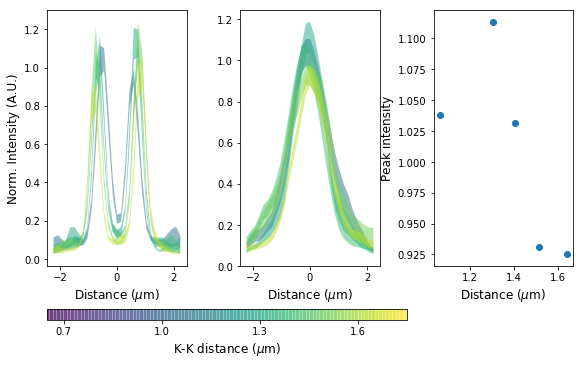

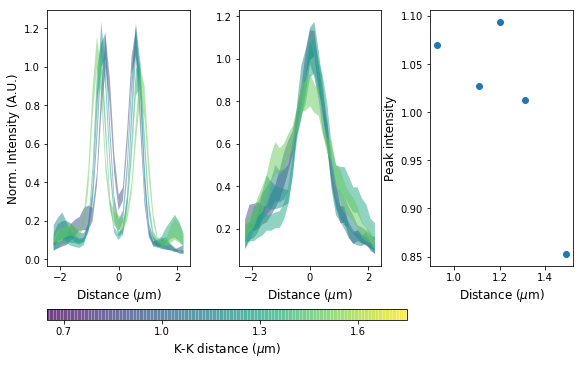

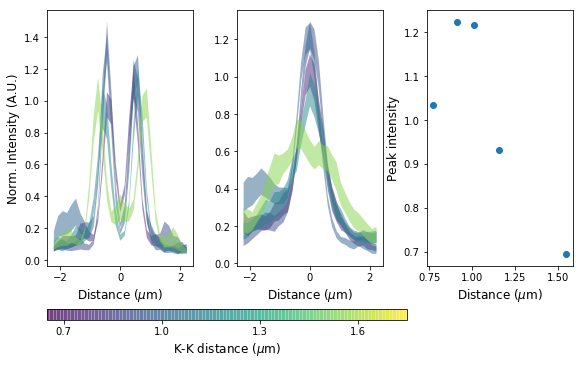

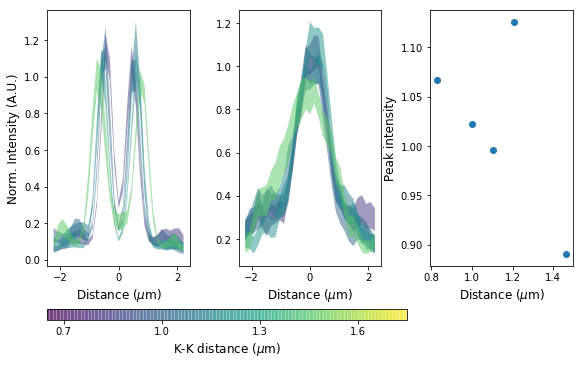

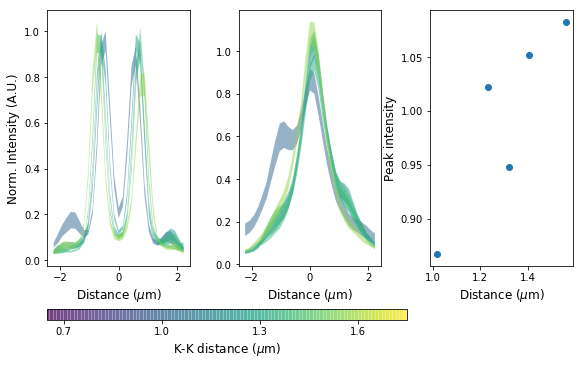

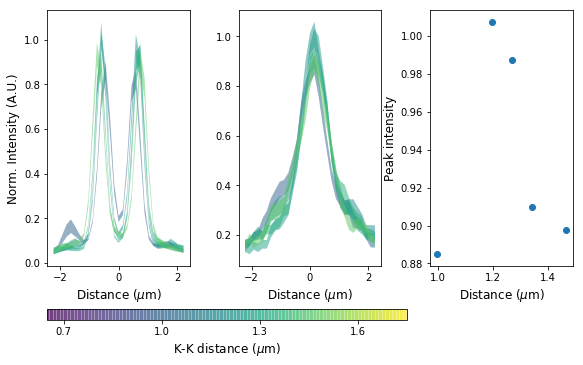

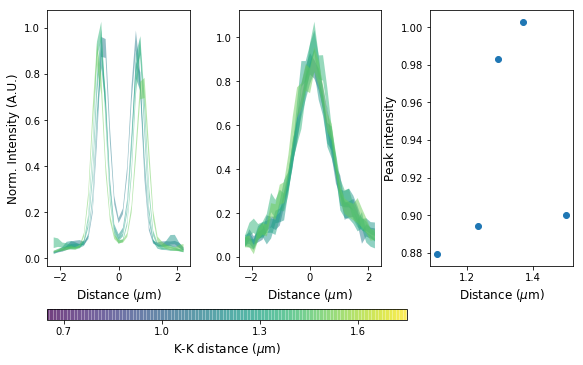

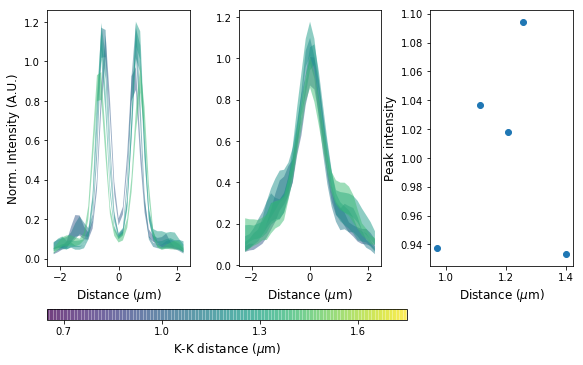

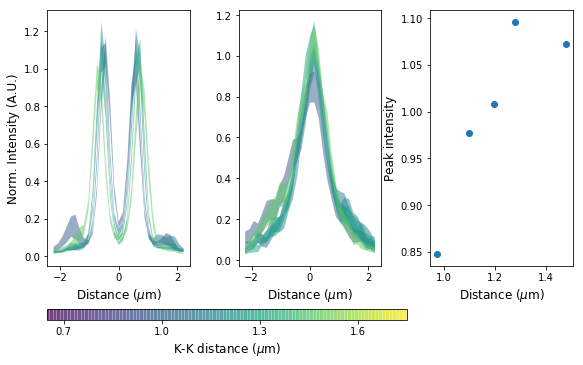

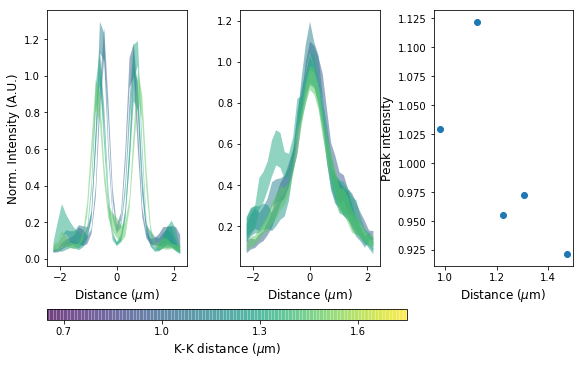

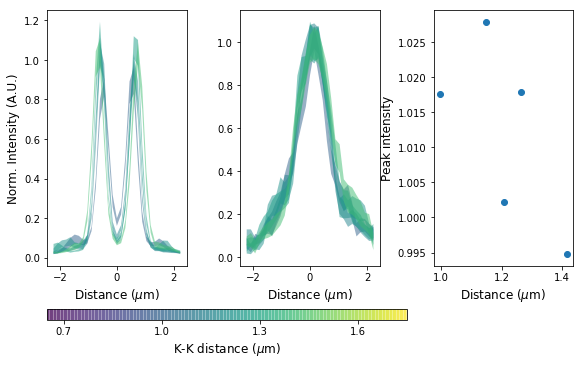

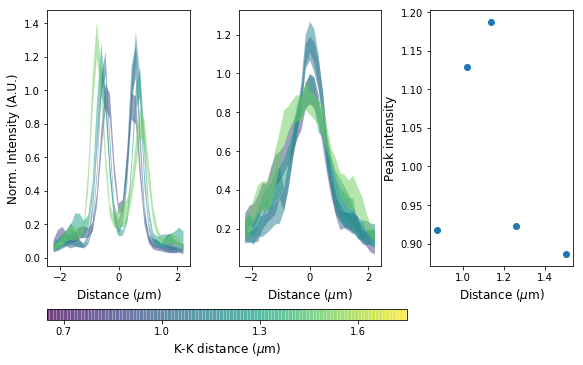

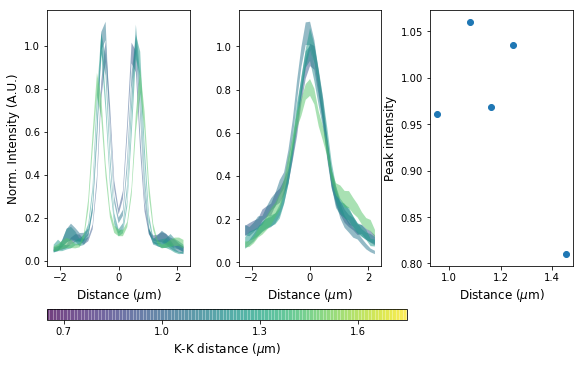

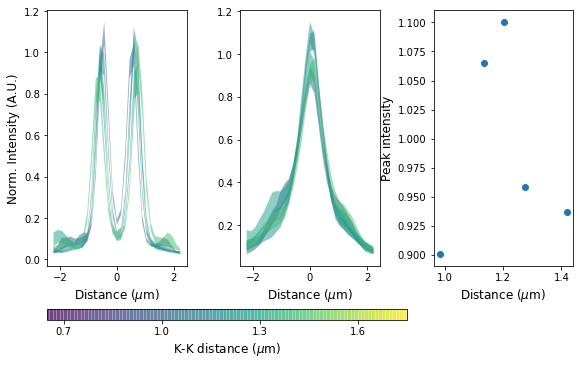

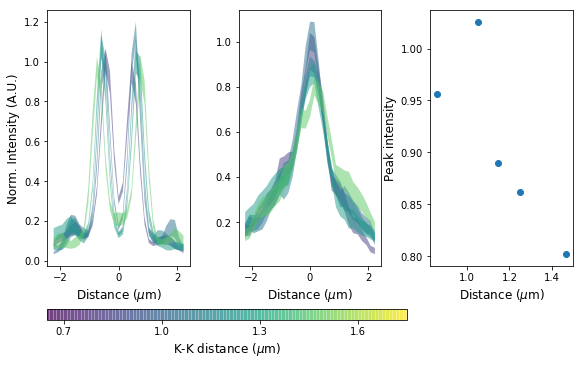

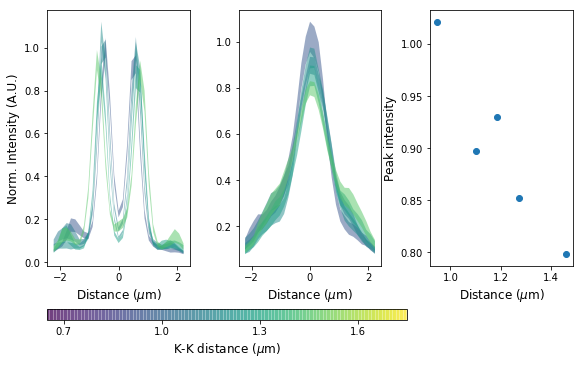

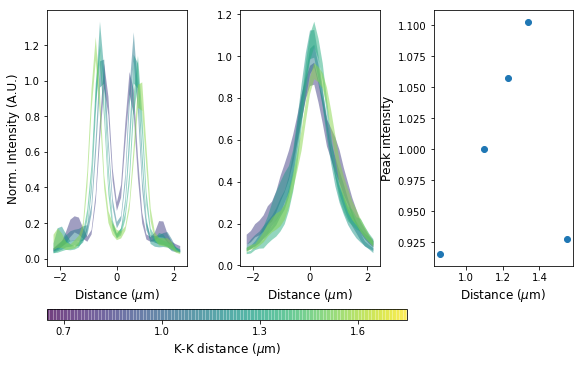

In [70]:
# Plot profiles for each cell
grps_to_plot = ['None','DMSO']
nbins = 5

df_select = df_prof_all.loc[[grp in grps_to_plot for grp in df_prof_all['Group']]]
df_grped = df_select.groupby('Data Name')

norm = mpl.colors.Normalize(vmin=kkdistrange[0],vmax=kkdistrange[1])
# choose a colormap
c_m = cm.viridis
# create a ScalarMappable and initialize a data structure
s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

proflen = len(df_select.iloc[0]['prof560_norm'])
x = (np.arange(proflen)-(proflen-1)/2.0)*pixsize

savedir = 'ProfilesForEachCells/'
for name, df in df_grped:
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(10,5))

    df_res = getBinAvgProf(df,nbins)
    for i in range(nbins):
        ax[0].fill_between(x,df_res.iloc[i]['avgprof488']+df_res.iloc[i]['semprof488'],
                        df_res.iloc[i]['avgprof488']-df_res.iloc[i]['semprof488'],alpha=alph,
                             facecolor=s_m.to_rgba(df_res.iloc[i]['avgkkdist']*pixsize))
        ax[1].fill_between(x,df_res.iloc[i]['avgprof560']+df_res.iloc[i]['semprof560'],
                        df_res.iloc[i]['avgprof560']-df_res.iloc[i]['semprof560'],alpha=alph,
                             facecolor=s_m.to_rgba(df_res.iloc[i]['avgkkdist']*pixsize))
    
    ax[2].plot(df_res['avgkkdist']*pixsize,df_res['avgprof560'].apply(np.max),'o')

    ax[0].set_ylabel('Norm. Intensity (A.U.)',fontsize=fs)
    ax[0].set_xlabel('Distance ($\mu$m)',fontsize=fs)
    ax[1].set_xlabel('Distance ($\mu$m)',fontsize=fs)
    ax[2].set_xlabel('Distance ($\mu$m)',fontsize=fs)
    ax[2].set_ylabel('Peak intensity',fontsize=fs)

    cax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
    cb = fig.colorbar(s_m,orientation='horizontal',cax=cax,ticks=[0.7,1.0,1.3,1.6],alpha=alph)
    cb.set_label('K-K distance ($\mu$m)',fontsize=fs)
    
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25,left=0.25)
    
    #fig.savefig(savedir+name+'_None&DMSO.pdf')


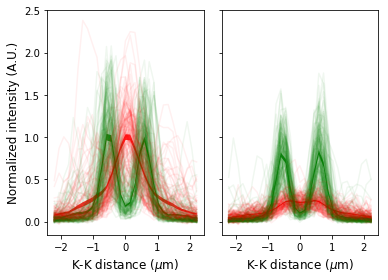

In [71]:
# Draw DMSO and 5ITu all grouped profiles

alph = 0.8
fs = 12
proflen = len(df_prof_all.iloc[0]['prof560_norm'])
x = (np.arange(proflen)-(proflen-1)/2.0)*pixsize

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(5.5,4),sharex=True,sharey=True)

grps_to_plot = ['None','5ITu']

for i,grp in enumerate(grps_to_plot):
    df_prof_select = df_prof_all.loc[(df_prof_all['Group']==grp) & (df_prof_all['Data Name']=='Set0_5ITu_03Pos6')]
    df_res = getBinAvgProf(df_prof_select,nbins=1,)
    
    for index,row in df_prof_select.iterrows():
        ax[i].plot(x,row['prof488_norm'],alpha=0.06,color='g')
        ax[i].plot(x,row['prof560_norm'],alpha=0.06,color='r')

    ax[i].fill_between(x,df_res.iloc[0]['avgprof488']+df_res.iloc[0]['semprof488'],
                       df_res.iloc[0]['avgprof488']-df_res.iloc[0]['semprof488'],alpha=alph,
                       facecolor='g')
    ax[i].fill_between(x,df_res.iloc[0]['avgprof560']+df_res.iloc[0]['semprof560'],
                       df_res.iloc[0]['avgprof560']-df_res.iloc[0]['semprof560'],alpha=alph,
                       facecolor='r')
    
ax[0].set_xlabel('K-K distance ($\mu$m)',fontsize=fs)
ax[1].set_xlabel('K-K distance ($\mu$m)',fontsize=fs)
ax[0].set_ylabel('Normalized intensity (A.U.)',fontsize=fs)

plt.tight_layout()

fig.savefig('Set0_5ITu_03Pos6_None_and_5ITu.pdf',facecolor=None,edgecolor=None)